In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import confusion_matrix, precision_score, recall_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.base import TransformerMixin
plt.style.use('ggplot')
plt.rcParams["font.size"] = 16

In [2]:
# read in data, change value names
df = pd.read_csv("loan_data_set.csv")
df = df.drop("Loan_ID", axis = 1)
df["Married"].replace({"No": "not_married", "Yes": "married"}, inplace=True)
df["Self_Employed"].replace({"No": "not_self_employed", "Yes": "self_employed"}, inplace=True)

In [3]:
df.isna().sum()

Gender               13
Married               3
Dependents           15
Education             0
Self_Employed        32
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount           22
Loan_Amount_Term     14
Credit_History       50
Property_Area         0
Loan_Status           0
dtype: int64

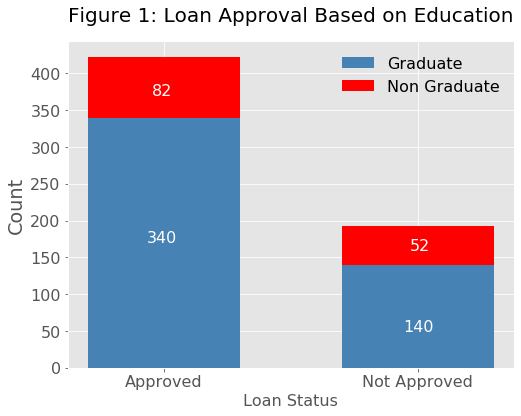

In [4]:
# Figure 1

# Break dataframe into graduates and non-graduates in order to find sum of loan approvals based on education
df_grad = df[df["Education"] == "Graduate"]
df_non_grad = df[df["Education"] == "Not Graduate"]


fig, ax = plt.subplots(figsize = (8,6))
labels = ["Approved", "Not Approved"]
grad_count = [sum(df_grad["Loan_Status"] == "Y"), sum(df_grad["Loan_Status"] == "N")]
non_grad_count = [sum(df_non_grad["Loan_Status"] == "Y"), sum(df_non_grad["Loan_Status"] == "N")]
ax.bar(labels, grad_count, label = "Graduate", width = .6, color = "steelblue")
ax.bar(labels, non_grad_count, label = "Non Graduate", width= .6, color = "r",bottom = grad_count)
ax.set_xlabel("Loan Status",size=16)
ax.set_ylabel("Count")
ax.set_title("Figure 1: Loan Approval Based on Education", pad = 20, size = 20)
ax.legend(frameon=False)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
plt.text(-0.07,170,str(int((sum(df_grad["Loan_Status"] == "Y")))),color = "w")
plt.text(-0.05,370,str(int((sum(df_non_grad["Loan_Status"] == "Y")))),color = "w")
plt.text(.97,160,str(int((sum(df_non_grad["Loan_Status"] == "N")))),color = "w")
plt.text(.944,50,str(int((sum(df_grad["Loan_Status"] == "N")))),color = "w")
None

In [5]:
# Use one-hot-encoding to transform the categorical data 
df_xcols = df

class OneHotTransformer(TransformerMixin):
    
    def __init__(self, cols):
        self.cols = cols
        
    def fit(self, train_df, y=None):
        return self

    def transform(self, df1):
        df1 = pd.DataFrame(df1, columns = self.cols)
        df2 = pd.DataFrame()
        for gender in ["Male", "Female"]:
            df2[gender] = (df1["Gender"] == gender).astype(int)
        for married in ["married", "not married"]:
            df2[married] = (df1["Married"] == married).astype(int)
        for educated in ["Graduate", "Not Graduate"]:
            df2[educated] = (df1["Education"] == educated).astype(int)
        for employed in ["not self employed", "self employed"]:
            df2[employed] = (df1["Self_Employed"] == employed).astype(int)
        for prop in ["Semiurban", "Urban", "Rural"]:
            df2[prop] = (df1["Property_Area"] == prop).astype(int)
        for dependents in ["0","1","2","3+"]:
            df2[dependents] = (df1["Dependents"] == dependents).astype(int)
        df = pd.concat((df1.drop(["Gender","Married","Education","Self_Employed", "Property_Area","Dependents"], axis = 1),
                          df2), axis =1)
        df = df.drop(columns = "Loan_Status")
        self.output_features_ = list(df.columns)
        return df

df_output = OneHotTransformer(df.columns).fit_transform(df_xcols)
df_output

,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Male,Female,married,not married,Graduate,Not Graduate,not self employed,self employed,Semiurban,Urban,Rural,0,1,2,3+
0,5849,0.0,NaN,360.0,1.0,1,0,0,0,1,0,0,0,0,1,0,1,0,0,0
1,4583,1508.0,128.0,360.0,1.0,1,0,1,0,1,0,0,0,0,0,1,0,1,0,0
2,3000,0.0,66.0,360.0,1.0,1,0,1,0,1,0,0,0,0,1,0,1,0,0,0
3,2583,2358.0,120.0,360.0,1.0,1,0,1,0,0,1,0,0,0,1,0,1,0,0,0
4,6000,0.0,141.0,360.0,1.0,1,0,0,0,1,0,0,0,0,1,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
609,2900,0.0,71.0,360.0,1.0,0,1,0,0,1,0,0,0,0,0,1,1,0,0,0
610,4106,0.0,40.0,180.0,1.0,1,0,1,0,1,0,0,0,0,0,1,0,0,0,1
611,8072,240.0,253.0,360.0,1.0,1,0,1,0,1,0,0,0,0,1,0,0,1,0,0
612,7583,0.0,187.0,360.0,1.0,1,0,1,0,1,0,0,0,0,1,0,0,0,1,0


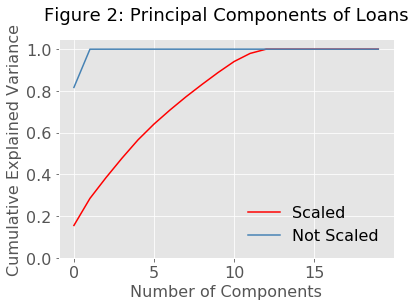

In [6]:
#Principal Component Analysis to explain the cumulative expected vaience 

df_xcols = df
df_xcols
fig, ax = plt.subplots()
pipe = Pipeline([
    ("imp", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotTransformer(df_xcols.columns)),
    ("std", StandardScaler()),
    ("pca", PCA())
])
projected = pipe.fit(df_xcols)
results = np.cumsum(pipe['pca'].explained_variance_ratio_)
results = pd.Series(results)
ax = results.plot.line(label="Scaled", ylim=0, color = 'red')

pipe = Pipeline([
    ("imp", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotTransformer(df_xcols.columns)),
    ("pca", PCA())
])
projected = pipe.fit(df_xcols)
results = np.cumsum(pipe['pca'].explained_variance_ratio_)
results = pd.Series(results)
results.plot.line(label="Not Scaled", ylim=0, ax=ax, color = "steelblue")
ax.legend(frameon=False)
ax.set_xlabel('Number of Components',size=16)
ax.set_ylabel('Cumulative Explained Variance',size=16);
ax.set_title("Figure 2: Principal Components of Loans", pad = 20, size = 18)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

In [15]:
# split the data into train and test datasets
train, test = train_test_split(df)
train = train.copy()
test = test.copy()
train["Loan_Status"] = train["Loan_Status"] == "Y"
test["Loan_Status"] = test["Loan_Status"] == "Y"
train.shape, test.shape

((460, 12), (154, 12))

Score 0.8376623376623377
Recall 0.9897959183673469
Precision 0.8016528925619835


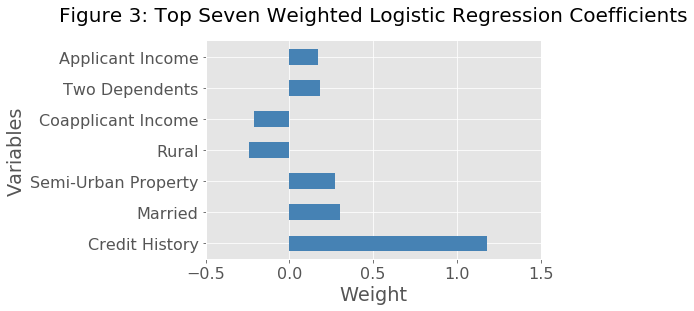

In [17]:
# Run logistic regression on the data, show which coefficents have the most weight
pipe = Pipeline([
    ("imp", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotTransformer(train.columns)),
    ("std", StandardScaler()),
    ("lr", LogisticRegression())
])

pipe.fit(train, train["Loan_Status"])
print("Score", pipe.score(test,test["Loan_Status"]))
print("Recall", recall_score(test["Loan_Status"], pipe.predict(test)))
print("Precision", precision_score(test["Loan_Status"], pipe.predict(test)))
variables = pipe["onehot"].output_features_
intercept = pipe["lr"].intercept_.round(2)[0]
coeffs = pipe["lr"].coef_.round(2)[0]
coeff_info = pd.DataFrame({"coeffs" : coeffs, 'abs_coeffs': abs(coeffs)}, index = variables)
coeff_info = coeff_info.sort_values(by = 'abs_coeffs', ascending = False)
coeff_info
coeff_info = coeff_info.head(7).drop(columns = 'abs_coeffs')
coeff_info
coeff_info = coeff_info.rename(index={'Credit_History': 'Credit History','Semiurban': 'Semi-Urban Property',
                         'LoanAmount': 'Loan Amount','2': 'Two Dependents',
                         'ApplicantIncome': 'Applicant Income', 'CoapplicantIncome': 'Coapplicant Income', 'married':'Married'})
ax = coeff_info.plot.barh(color = "steelblue")
ax.get_legend().remove()
ax.set_title("Figure 3: Top Seven Weighted Logistic Regression Coefficients",size=20, pad = 20)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.set_ylabel("Variables")
ax.set_xlabel("Weight")
plt.xticks(np.arange(-0.5,2,0.5))
None